### Data Cleaning and Validation

#### Load and check data

In [ ]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load data into dataframe
airtraffic_df = pd.read_csv("data.csv")

In [ ]:
# Look at a couple of rows to get a feel for the data
airtraffic_df.head(10)

In [ ]:
# Display shape and type of each variable in the dataframe
airtraffic_df.info()

In [ ]:
# Get summary statistics for the data
airtraffic_df.describe()

Here are the variables that need to change
- Month -> String
- AustralianPort -> String
- ForeignPort -> String
- Country -> String

All other varaibles are already of suitable type

#### Convert variable types

In [ ]:
# Convert all of the nessesary varaibles
changed_varaibles = ["Month", "AustralianPort", "ForeignPort", "Country"]

for variable in changed_varaibles:
    airtraffic_df[variable] = airtraffic_df[variable].astype("string")

# Check if changes worked
airtraffic_df.info()

#### Check Null Values

In [ ]:
# Check the frequency of null values in each column
airtraffic_df.isnull().sum()

In [ ]:
# Check the frequency of null values in each row
airtraffic_df.isnull().sum(axis=1).sort_values(ascending = False)

No null values in the dataset so no need for data manipulation.

In [ ]:
# Check if there are any complete duplicate rows
duplicates = airtraffic_df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

# If you want to see the actual duplicate rows
if duplicates.sum() > 0:
    duplicate_rows = airtraffic_df[duplicates]
    display(duplicate_rows)

#### Data Validation

In [ ]:
# Check numberical columns are positive
numerical_cols = ['Passengers_In', 'Passengers_Out', 'Passengers_Total', 
                  'Freight_In_(tonnes)', 'Freight_Out_(tonnes)', 'Freight_Total_(tonnes)',
                  'Mail_In_(tonnes)', 'Mail_Out_(tonnes)', 'Mail_Total_(tonnes)']

for col in numerical_cols:
    invalid_mask = airtraffic_df[col] < 0
    invalid_count = invalid_mask.sum()

print(f"Number of invalid rows: {invalid_count}")

In [ ]:
# Check month_num is within 1-12
invalid_months = len(airtraffic_df[(airtraffic_df['Month_num'] < 1) | (airtraffic_df['Month_num'] > 12)])

print(f"Number of rows with an invalid month_num: {invalid_months}")

#### Column Generation

In [ ]:
# Add proper datetime columns for easier comparison
airtraffic_df["Month_dt"] = pd.to_datetime(
    airtraffic_df["Month"], 
    format="%b-%y"
)

# Check if it worked
airtraffic_df[["Month", "Month_dt"]].head()

### EDA

#### Find most and least trafficked routes

In [ ]:
# Analysis of most and least bidirectional trafficked routes
route_summary = airtraffic_df.groupby(["AustralianPort", "ForeignPort"]).agg({"Passengers_Total": "sum", "Freight_Total_(tonnes)": "sum", "Mail_Total_(tonnes)": "sum"})

# Metrics to visualize
metrics = {
    "Passengers_Total": "Total Passengers",
    "Freight_Total_(tonnes)": "Total Freight (tonnes)",
    "Mail_Total_(tonnes)": "Total Mail (tonnes)"
}

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 6 * len(metrics)))


if len(metrics) == 1:
    axes = [axes]

for ax, (col, label) in zip(axes, metrics.items()):
    top_routes = route_summary.sort_values(col, ascending=False).head(5)
    top_routes = top_routes.reset_index() 
    top_routes["Route"] = top_routes["AustralianPort"] + " ↔ " + top_routes["ForeignPort"]    

    sns.barplot(
        x=col,
        y="Route",
        hue="Route", 
        data=top_routes,
        ax=ax,
        dodge=False,
        legend=False, 
        palette="viridis"
    )
    
    ax.set_title(f"Top 5 Bidirectional Routes by {label}")
    ax.set_xlabel(label)
    ax.set_ylabel("Route")

plt.tight_layout()
plt.show()

In [ ]:
def plot_route_traffic(route_summary, metrics, top_n=10, bottom_n=10, bidirectional=False):
    """
    Plots separate charts for top and bottom trafficked routes for each metric.
    
    Parameters:
        route_summary (pd.DataFrame): Aggregated route DataFrame
        metrics (dict): Dictionary of metrics to plot. 
                        For single-direction: {"Passengers_Out": "Passengers_Out"}
                        For bidirectional: {"Passengers_Total": ("Passengers_In", "Passengers_Out")}
        top_n (int): Number of top routes to display
        bottom_n (int): Number of bottom routes to display
        bidirectional (bool): If True, sum In+Out for each metric
    """
    
    sns.set_theme(style="whitegrid")
    
    direction_map = {"In": "←", "Out": "→", "Both": "↔"}
    
    df = route_summary.copy().reset_index()
    
    for name, col in metrics.items():
        # Compute total if bidirectional
        if bidirectional:
            in_col, out_col = col
            df[name + "_Total"] = df[in_col] + df[out_col]
            plot_col = name + "_Total"
            arrow = direction_map["Both"]
        else:
            plot_col = col
            arrow = direction_map["Out"] if "Out" in col else direction_map["In"]
        
        # Create route labels with appropriate arrow
        df["Route"] = df["AustralianPort"] + f" {arrow} " + df["ForeignPort"]
        
        # --- Top routes ---
        top_routes = df.sort_values(plot_col, ascending=False).head(top_n).copy()
        plt.figure(figsize=(12, 6))
        sns.barplot(
            x=plot_col,
            y="Route",
            hue="Route",
            data=top_routes,
            legend=False,
            palette="Blues_d"
        )
        plt.title(f"Most Trafficked Routes by {name}")
        plt.xlabel(name if not bidirectional else f"Total {name}")
        plt.ylabel("Route")
        plt.tight_layout()
        plt.show()
        
        # --- Bottom routes ---
        bottom_routes = df[df[plot_col] > 0].sort_values(plot_col, ascending=True).head(bottom_n).copy()
        plt.figure(figsize=(12, 6))
        sns.barplot(
            x=plot_col,
            y="Route",
            hue="Route",
            data=bottom_routes,
            legend=False,
            palette="Reds_d"
        )
        plt.title(f"Least Trafficked Routes by {name}")
        plt.xlabel(name if not bidirectional else f"Total {name}")
        plt.ylabel("Route")
        plt.tight_layout()
        plt.show()


In [ ]:
# Get aggregated totals for each port
route_summary = airtraffic_df.groupby(["AustralianPort", "ForeignPort"]).agg({"Passengers_In": "sum", "Passengers_Out": "sum", "Freight_In_(tonnes)": "sum", 
                                                                              "Freight_Out_(tonnes)": "sum", "Mail_In_(tonnes)": "sum", "Mail_Out_(tonnes)": "sum"})

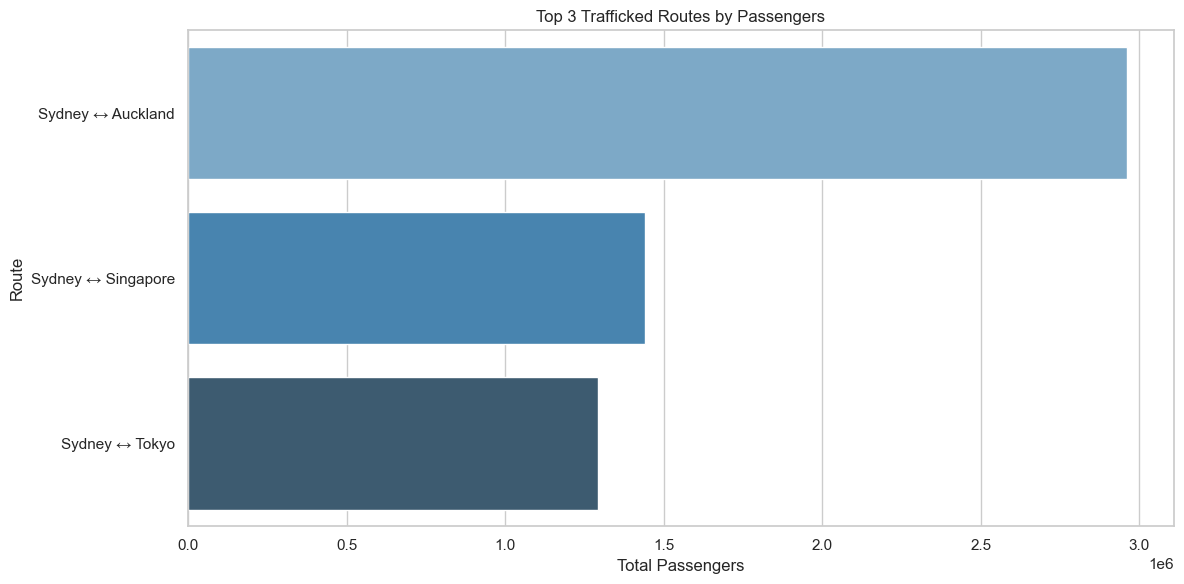

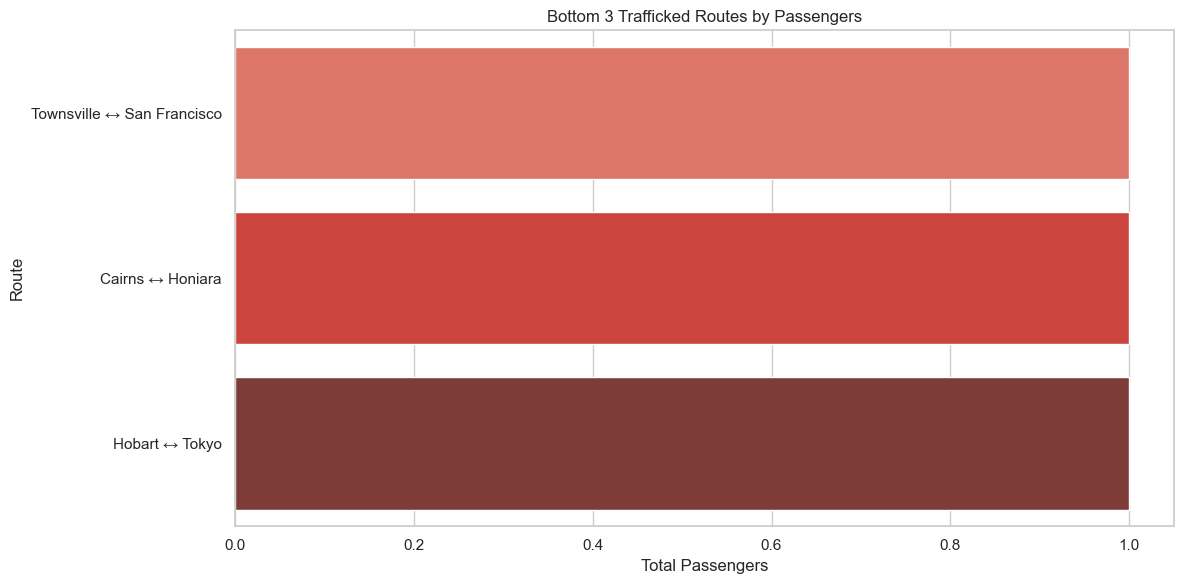

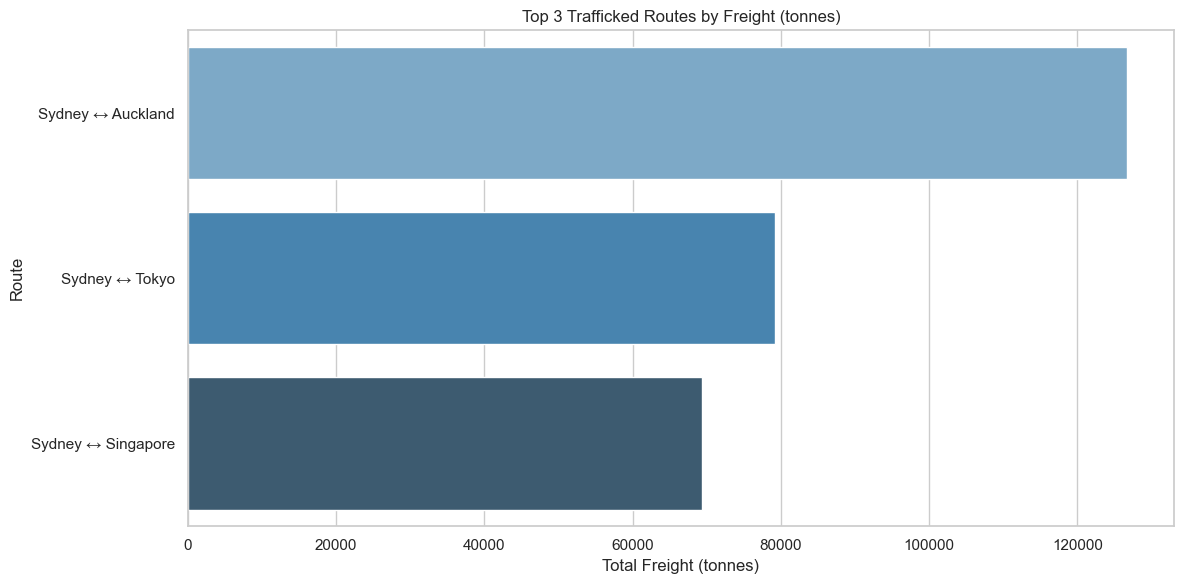

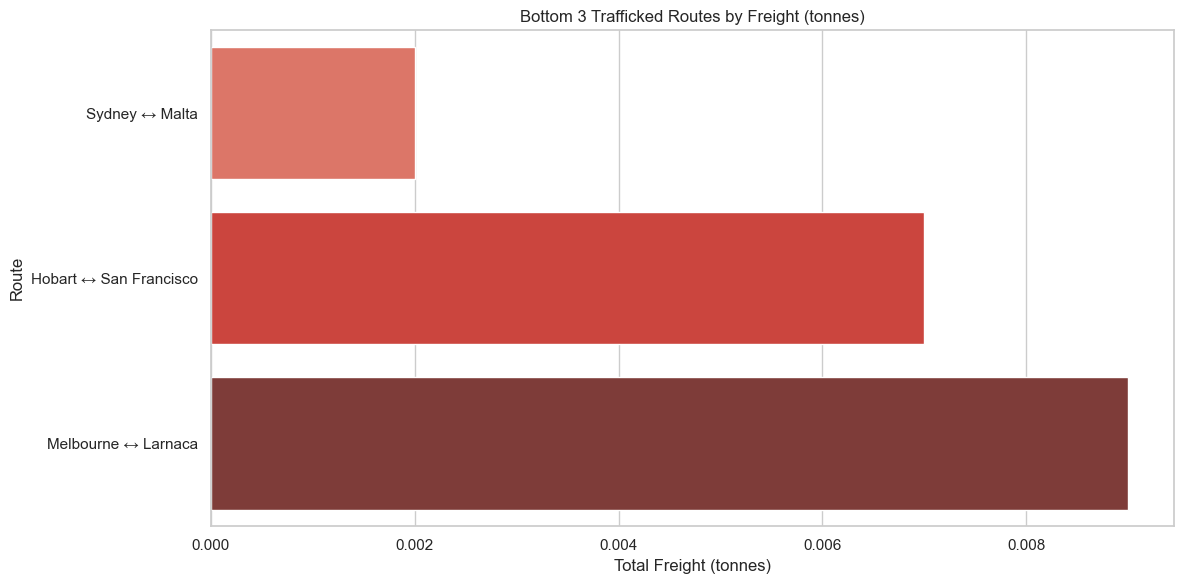

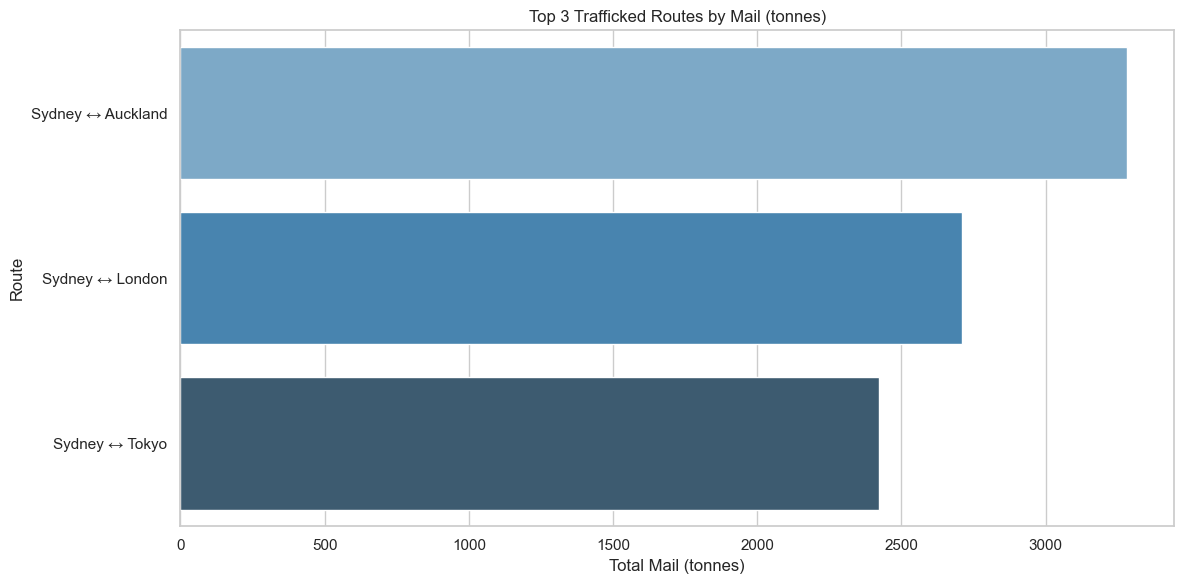

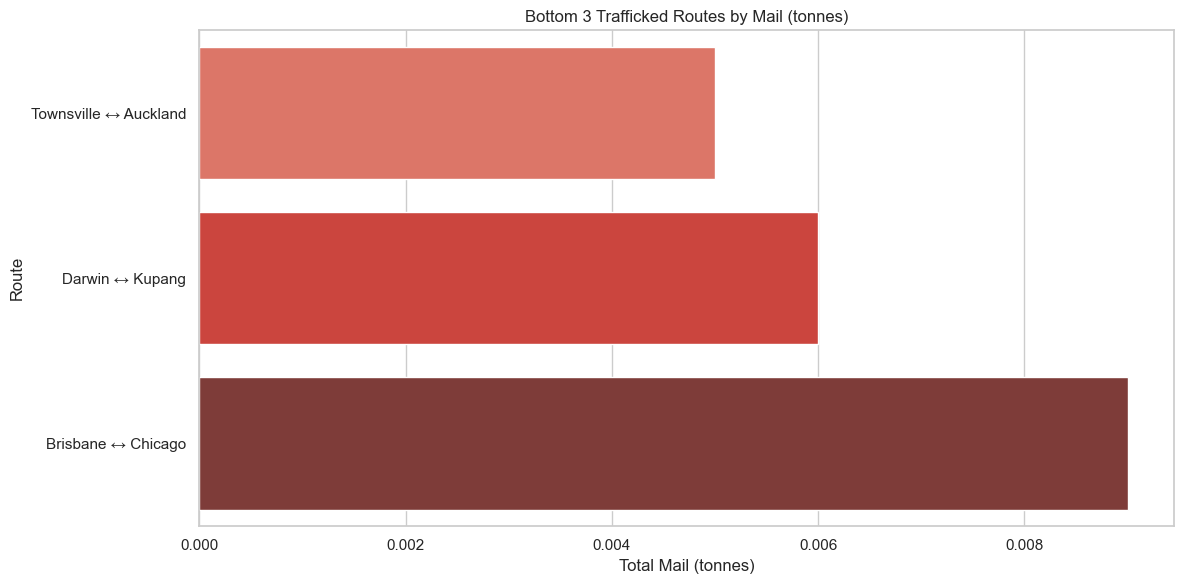

In [166]:
# Define metrics dictionary for bidirectional totals
metrics_bidirectional = {
    "Passengers": ("Passengers_In", "Passengers_Out"),
    "Freight (tonnes)": ("Freight_In_(tonnes)", "Freight_Out_(tonnes)"),
    "Mail (tonnes)": ("Mail_In_(tonnes)", "Mail_Out_(tonnes)")
}

# Call the function with bidirectional=True
plot_route_traffic(route_summary, metrics_bidirectional, top_n=3, bottom_n=3, bidirectional=True)

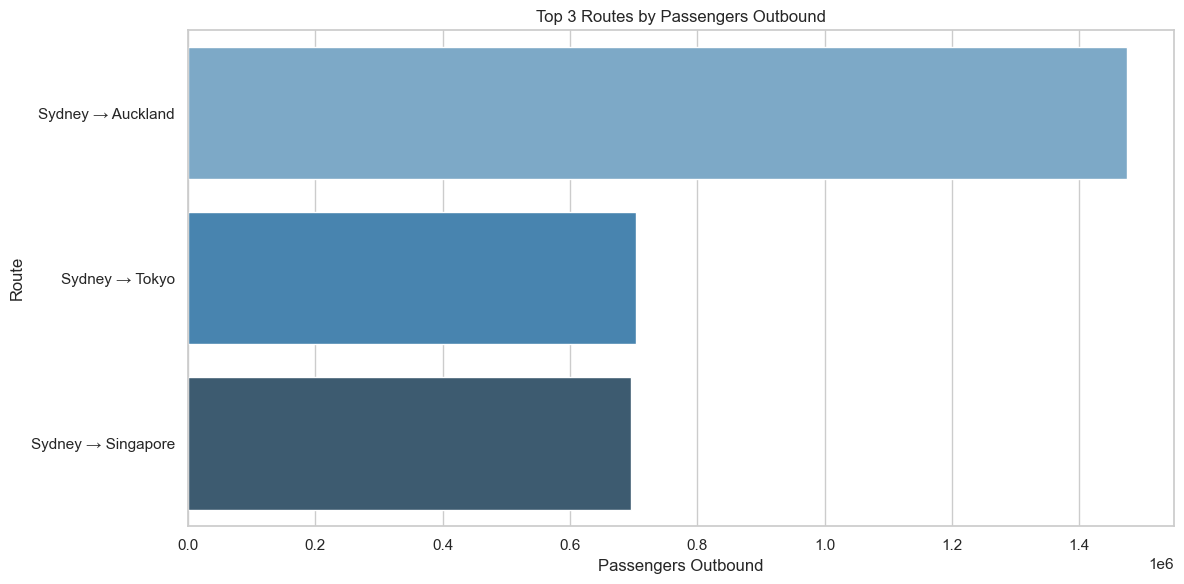

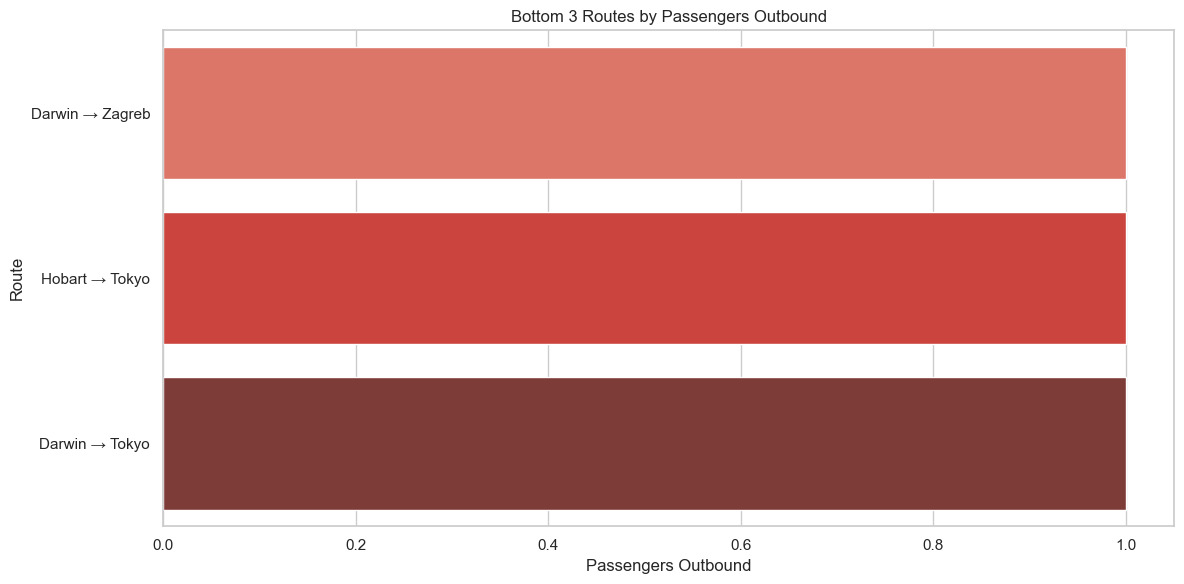

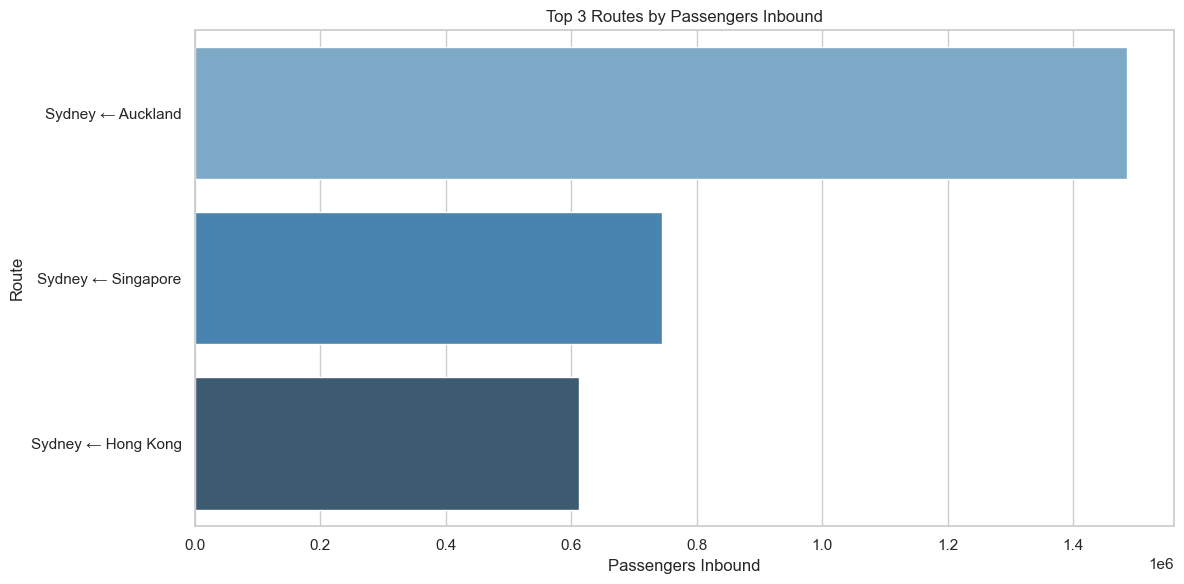

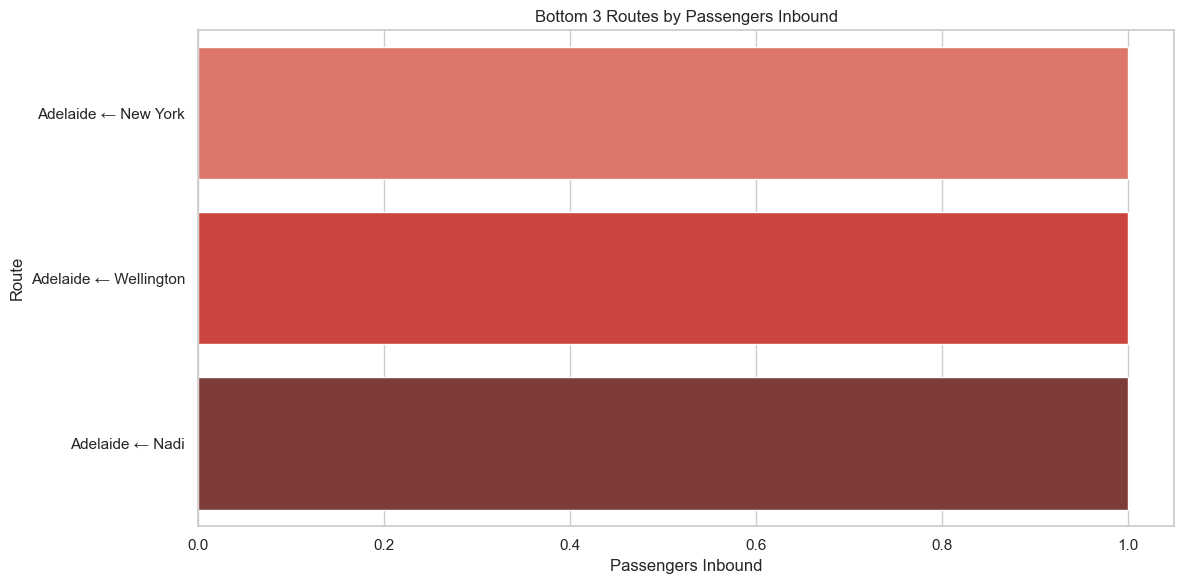

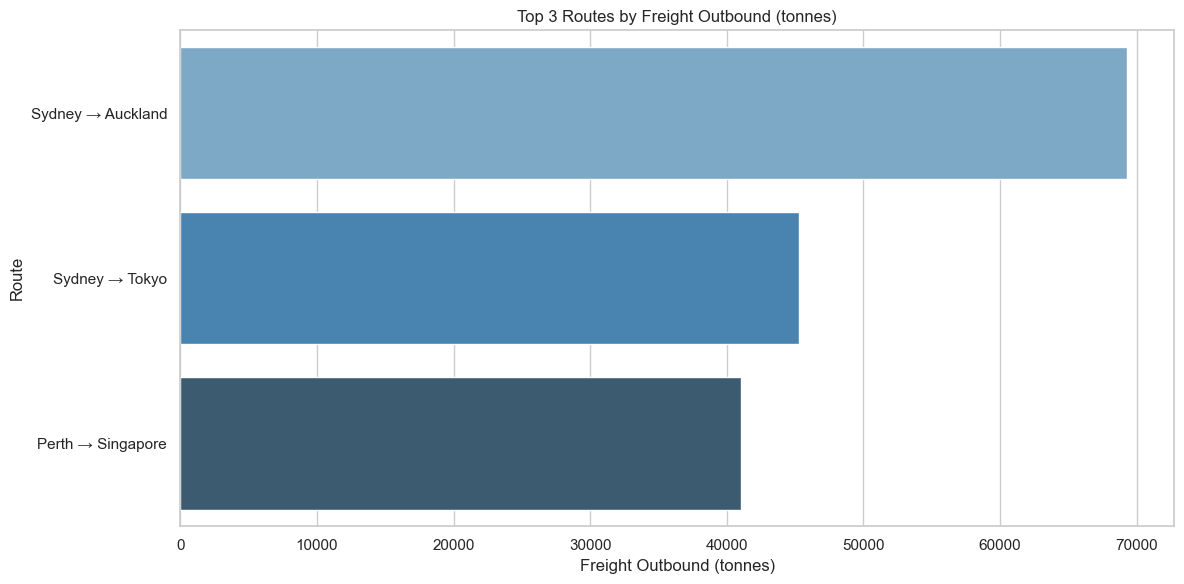

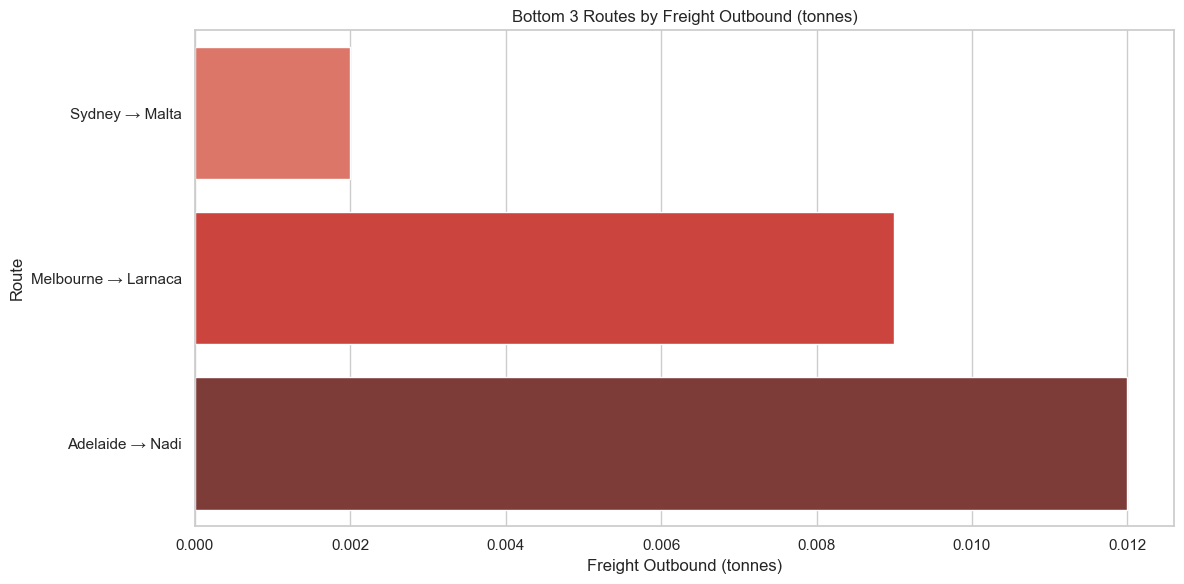

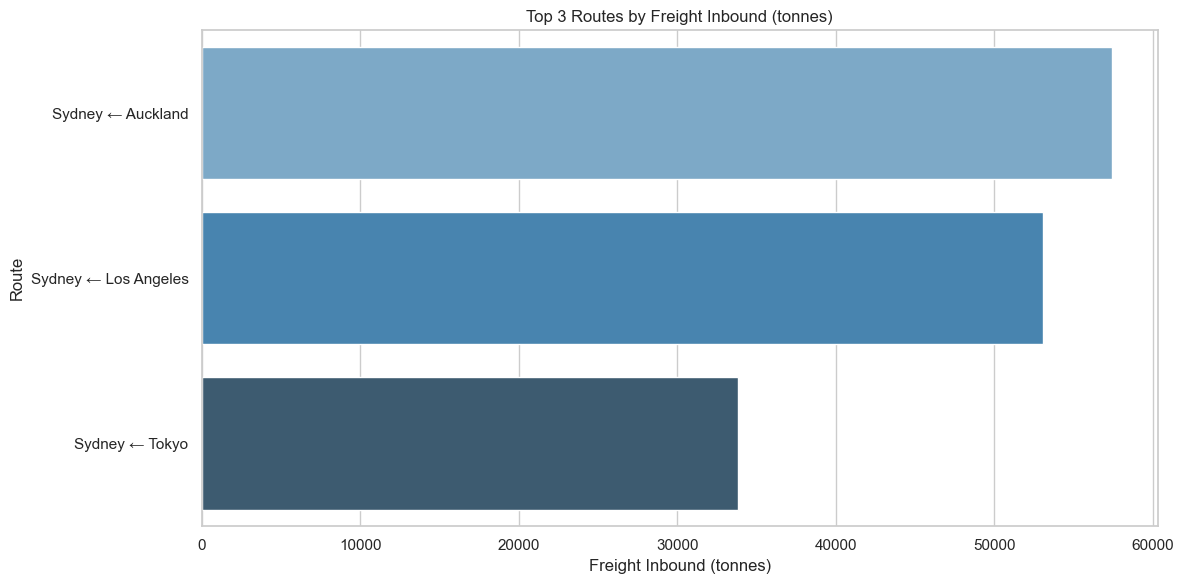

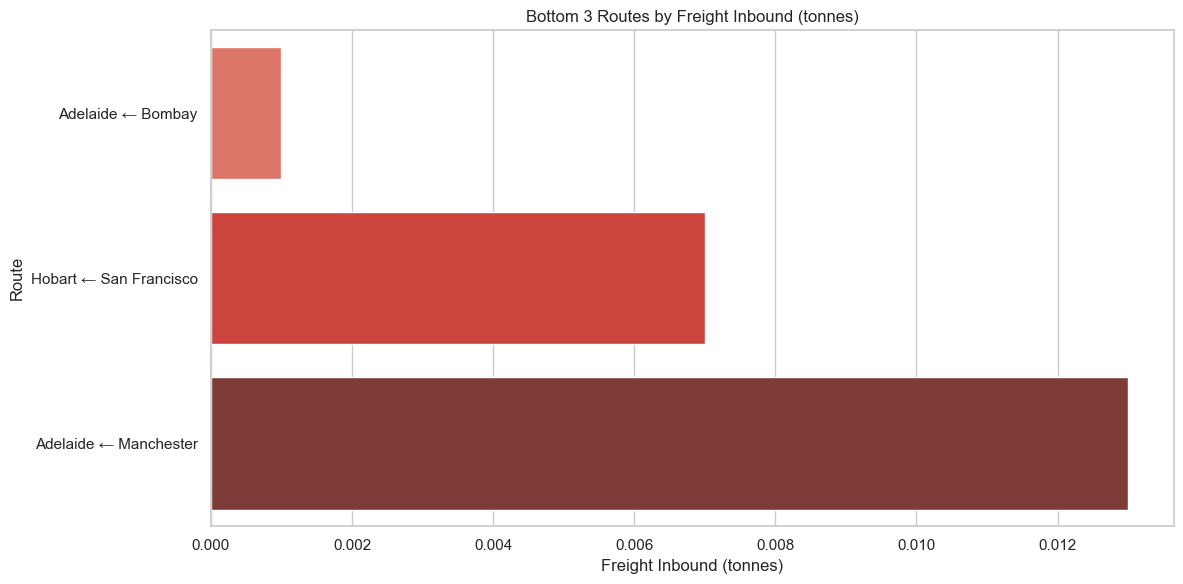

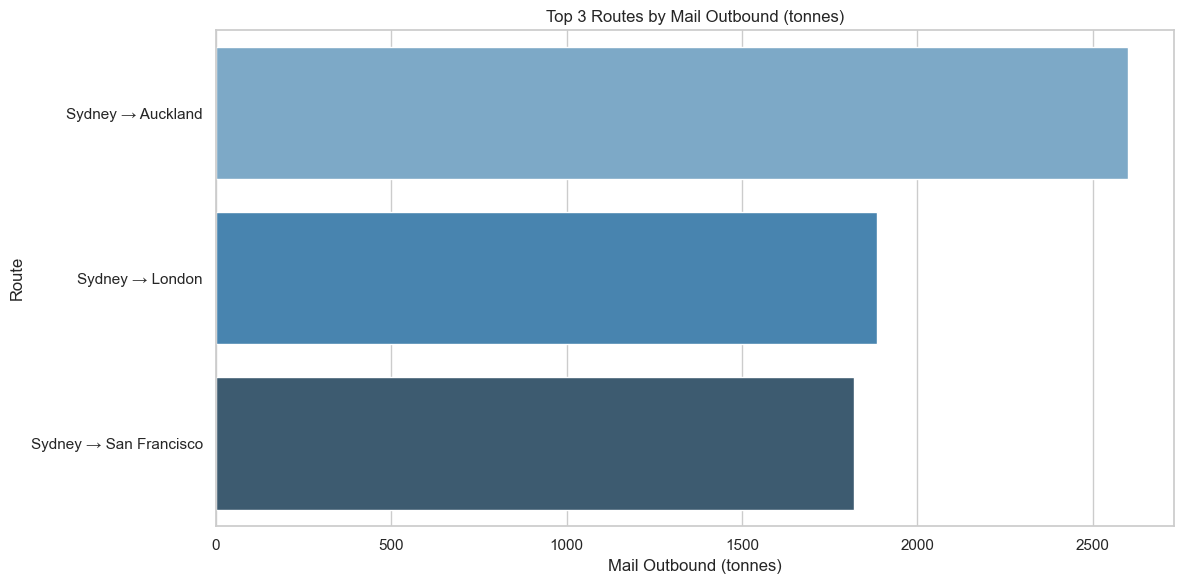

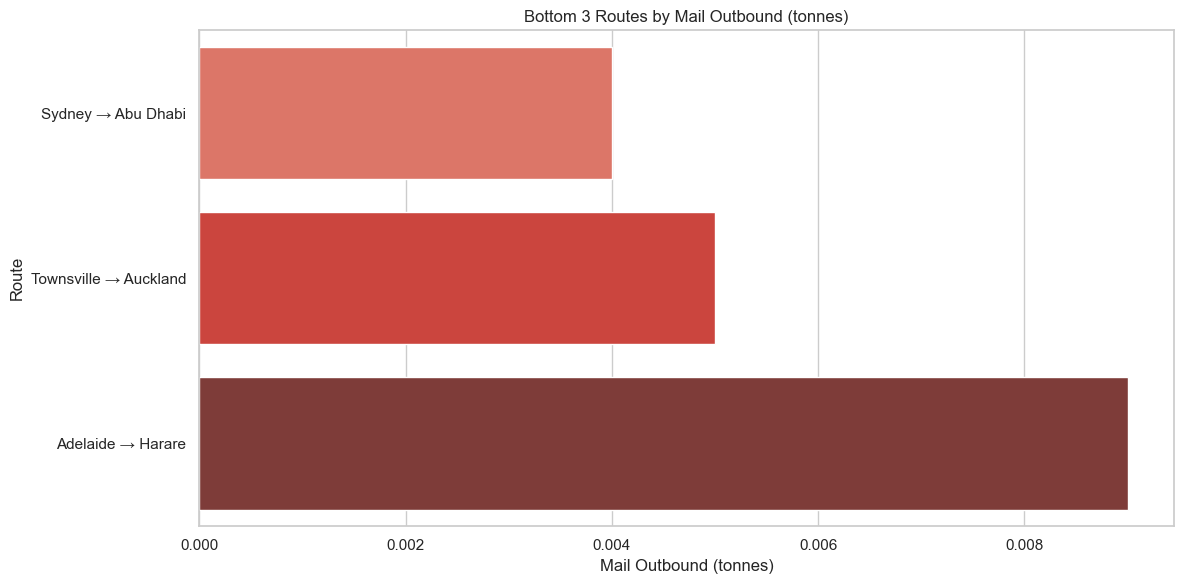

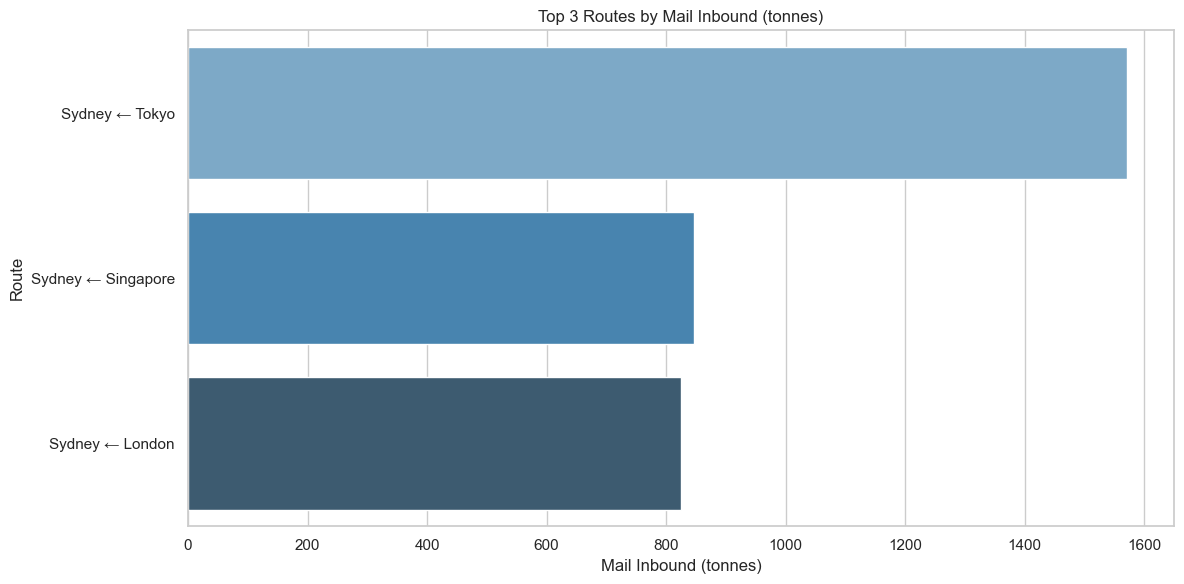

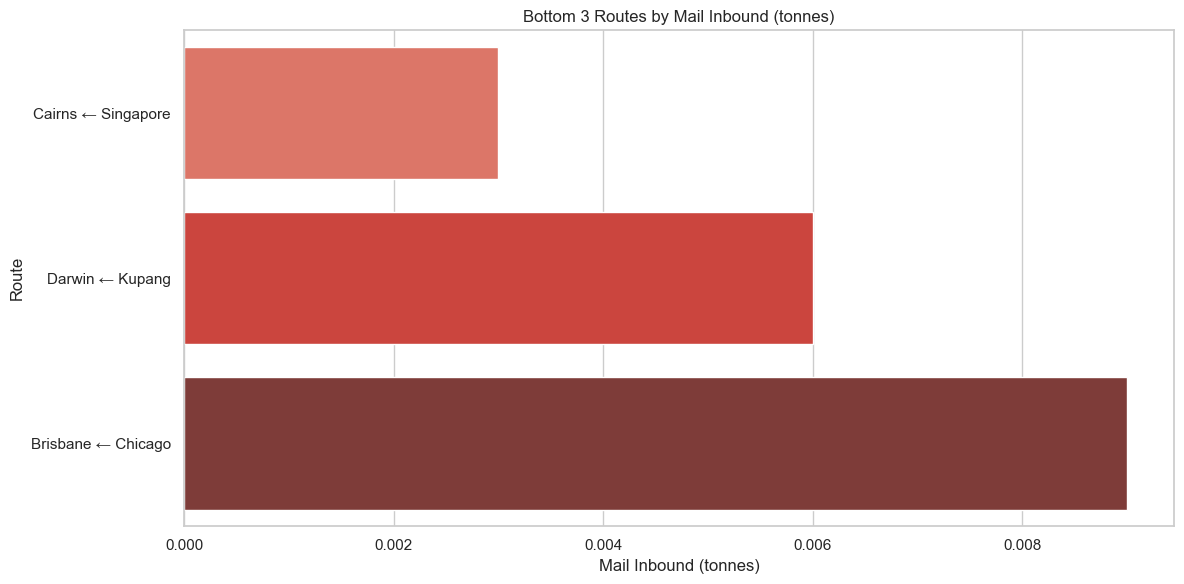

In [164]:
# Define metrics dictionary for single-direction analysis
metrics_all = {
    "Passengers Outbound": "Passengers_Out",
    "Passengers Inbound": "Passengers_In",
    "Freight Outbound (tonnes)": "Freight_Out_(tonnes)",
    "Freight Inbound (tonnes)": "Freight_In_(tonnes)",
    "Mail Outbound (tonnes)": "Mail_Out_(tonnes)",
    "Mail Inbound (tonnes)": "Mail_In_(tonnes)"
}

# Call the existing function
plot_route_traffic(route_summary, metrics_all, top_n=3, bottom_n=3, bidirectional=False)